In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from dataclasses import dataclass

import json

from icecream import ic

from pymatching import MatchingJax as Matching

import jax
import jax.numpy as jnp

key = jax.random.key(42)

In [2]:
def flatten_list(nested_list: list[list]) -> list:
    result = []
    for elm in nested_list:
        if isinstance(elm, list):
            result.extend(flatten_list(elm))
        else:
            result.append(elm)
    return result

def get_elm(nested_list: list[list], index: list[int]):
    if len(index) == 1:
        return nested_list[index[0]]
    else:
        return get_elm(nested_list[index[0]], index[1:])

In [3]:
@dataclass
class Deform:
    I = 0
    XZ = ZX = 1
    YZ = ZY = 2
    XY = YX = 3
    XYZ = YZX = ZXY = 4
    XZY = ZYX = YXZ = 5

deformations = jnp.array([  # The different Clifford deformations (neglecting the phase)
    [0, 1, 2, 3], # 0: I
    [0, 3, 2, 1], # 1: XZ
    [0, 1, 3, 2], # 2: YZ
    [0, 2, 1, 3], # 3: XY
    [0, 2, 3, 1], # 4: XYZ
    [0, 3, 1, 2]] # 5: XZY
)

deformations_inv = jnp.array([  # The inverse of `deformations`
    [0, 1, 2, 3], # 0: I
    [0, 3, 2, 1], # 1: XZ
    [0, 1, 3, 2], # 2: YZ
    [0, 2, 1, 3], # 3: XY
    [0, 3, 1, 2], # 4: XYZ
    [0, 2, 3, 1]] # 5: XZY
)

In [4]:
def surface_code_data(distance: int) -> dict:
    d = distance
    data = {
        "Data qubit": {
            "type": "data",
            "qubit": [[{
                "loc": (i,j,0),
                "conn": [
                    {
                        "group": "Type A syndrome qubits",
                        "idxs": [(i,j), (i+1,j+1)]
                    },
                    {
                        "group": "Type A syndrome qubits",
                        "idxs": [(i,j+1), (i+1,j)]
                    },
                    {
                        "group": "Type B syndrome qubits",
                        "idxs": [(i,j), (i+1,j+1)]
                    },
                    {
                        "group": "Type B syndrome qubits",
                        "idxs": [(i,j+1), (i+1,j)]
                    },
                ],
                "deformation": Deform.I # Regular surface code
                # "deformation": Deform.ZY # The XY surface code
                # "deformation": Deform.I if (j+i)%2 == 0 else Deform.XZ # XZZX surface code
                # "deformation": [[Deform.YZ, Deform.XZ], [Deform.I, Deform.YZ]][i%2][j%2] # C1 surface code
            } for j in range(d)] for i in range(d)],
            "plt_style": {"marker": "o", "ls": '', 'mec': '#000000'},
            "error_color": ['#000000', '#990000', '#009900', '#000099'],
            "pauli_colors": ['#000000', '#E53629', '#2CD23E', '#4149C3'],
            "plt_connect_style": {"marker": ''}
        },
        "Type A syndrome qubits": {
            "type": "synd",
            "pauli": 1, # X
            "qubit": [[{
                    "loc": (i-.5,j-.5,0) if 0<j<d and (i+j)%2 == 1 else None
                } for j in range(d+1)] for i in range(d+1)],
            "plt_style": {"marker": "s", "ls": '', 'mec': '#000000'},
            "state_colors": ['#2B2A33', '#D76C43']
        },
        "Type B syndrome qubits": {
            "type": "synd",
            "pauli": 3, # Z
            "qubit": [[{
                    "loc": (i-.5,j-.5,0) if 0<i<d and (i+j)%2 == 0 else None
                } for j in range(d+1)] for i in range(d+1)],
            "plt_style": {"marker": "D", "ls": '', 'mec': '#000000'},
            "state_colors": ['#2B2A33', '#D76C43']
        },
    }
    return _transpile_data(data)

def _transpile_data(data: dict) -> dict:
    def flatten_list(nested_list: list[list]) -> list:
        result = []
        for elm in nested_list:
            if isinstance(elm, list):
                result.extend(flatten_list(elm))
            else:
                result.append(elm)
        return result

    def get_elm(nested_list: list[list], index: list[int]):
        if len(index) == 1:
            return nested_list[index[0]]
        else:
            return get_elm(nested_list[index[0]], index[1:])

    def index_data(data: dict) -> dict:
        """
        Assignes an index to all the qubits that have a location.
        """
        for group in data:
            match data[group]["type"]:
                case "data":
                    idx = 0
                    for qubit in flatten_list(data[group]['qubit']):
                        if qubit['loc'] is not None:
                            qubit['index'] = idx
                            idx += 1
                case "synd":
                    idx = 0
                    for qubit in flatten_list(data[group]['qubit']):
                        if qubit['loc'] is not None:
                            qubit['index'] = idx
                            idx += 1
                case _:
                    raise NameError(f"No method for handling group of type: {data[group]["type"]}")
        return data

    def clenup_data(data: dict) -> dict:
        """
        Flattens all the nested lists by using the assigned index for each qubit
        """
        clean_data = {}
        for group in data:
            match data[group]["type"]:
                case "data":
                    clean_data[group] = data[group].copy()
                    clean_data[group]['qubit'] = []
                    for qubit in flatten_list(data[group]['qubit']):
                        if qubit.get('index', None) is None:
                            continue
                        qubit_ = qubit.copy()
                        # qubit_.pop('index')
                        qubit_['conn'] = []
                        for connection in qubit['conn']:
                            s1 = get_elm(data[connection['group']]['qubit'], connection['idxs'][0])
                            s1_found = s1.get('index', None) is not None
                            s2 = get_elm(data[connection['group']]['qubit'], connection['idxs'][1])
                            s2_found = s2.get('index', None) is not None
                            idxs = []
                            if s1_found:
                                idxs.append(s1['index'])
                            if s2_found:
                                idxs.append(s2['index'])
                            if len(idxs) > 0:
                                qubit_['conn'].append({
                                    "group": connection['group'],
                                    "idxs": idxs
                                })
                        clean_data[group]['qubit'].append(qubit_)
                case "synd":
                    clean_data[group] = data[group].copy()
                    clean_data[group]['qubit'] = []
                    for qubit in flatten_list(data[group]['qubit']):
                        if qubit.get('index', None) is None:
                            continue
                        qubit_ = qubit.copy()
                        # qubit_.pop('index')
                        clean_data[group]['qubit'].append(qubit_)
                case _:
                    raise NameError(f"No method for handling group of type: {data[group]["type"]}")
        return clean_data
    
    return clenup_data(index_data(data))

data = surface_code_data(distance=3)
with open("TestData.json", 'w') as file:
    json.dump(data, file, indent=4)

In [5]:
def get_qubit_count(data: dict):
    num_dq = {}
    num_sq = {}
    for group in data:
        match data[group]["type"]:
            case "data":
                num_dq[group] = num_dq.get(group, 0) + len(data[group]['qubit'])
            case "synd":
                num_sq[group] = num_sq.get(group, 0) + len(data[group]['qubit'])
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    return {'dq': num_dq, 'sq': num_sq}

qubit_counts = get_qubit_count(data)
qubit_counts

{'dq': {'Data qubit': 9},
 'sq': {'Type A syndrome qubits': 4, 'Type B syndrome qubits': 4}}

In [6]:
def parity_check_matrix(data: dict) -> dict[jnp.ndarray]:
    count = get_qubit_count(data)
    H = {name: [[0 for _ in range(sum(count['dq'].values()))] for _ in range(count['sq'][name])] 
         for name, content in data.items() if content["type"] == "synd"}
    d_idx = 0
    for group in data:
        if data[group]["type"] != "data":
            continue
        for qubit_d in data[group]["qubit"]:
            for connection in qubit_d['conn']:
                group_s = connection['group']
                for s_idx in connection['idxs']:
                    H[group_s][s_idx][d_idx] = 1
            d_idx += 1
    return {k: jnp.array(v) for k, v in H.items()}


H = parity_check_matrix(data)
for group, h in H.items():
    print(group)
    print(h)
    print()

Type A syndrome qubits
[[1 1 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1]]

Type B syndrome qubits
[[1 1 0 1 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 1 0 1 1]]



In [7]:
code_deformations = jnp.array([qubit['deformation'] for qubit in data['Data qubit']['qubit']])

def deform_batch(error_batch, code_deformations):
    sellected_deformations = deformations[code_deformations]
    indices = jnp.arange(sellected_deformations.shape[0])
    return sellected_deformations[indices, error_batch[:]]

def deform_batch_inv(error_batch, code_deformations):
    sellected_deformations = deformations_inv[code_deformations]
    indices = jnp.arange(sellected_deformations.shape[0])
    return sellected_deformations[indices, error_batch[:]]

def jax_create_error_batch(px: float, py: float, pz: float, size: int, batch_size: int, key) -> jnp.ndarray:
    """
    Create a batch of errors

    `px`, `py`, `pz`: The error probabilities (must sum to less than one)

    `size`: the number of errors in each batch

    `batch_size`: The number of batches to generate
    """
    if px+py+pz > 1:
        raise ValueError(f"The sum of the probabilies exceed one px+py+pz = {px+py+pz} > 1")
    def jax_create_error(px: float, py: float, pz: float, size: int, key) -> jnp.ndarray:
        rand = jax.random.uniform(key, shape=(size))
        return jnp.where(rand < py+pz, jnp.where(rand < pz, 3, 2), jnp.where(rand < px+py+pz, 1, 0))
    keys = jax.random.split(key, batch_size)
    batch_created_errors = jax.vmap(
        jax_create_error,
        in_axes=(None, None, None, None, 0),
        out_axes=0)
    return batch_created_errors(px, py, pz, size, keys)

In [8]:
def logical_error_batch(errors, code_deformations):
    code_distance = jnp.sqrt(qubit_counts['dq']['Data qubit']).astype(int)
    undeformed_errors = deform_batch_inv(errors, code_deformations)
    v_err = undeformed_errors[:,:code_distance]  # Takes the first vertical line of qubits (left most line)
    h_err = undeformed_errors[:,::code_distance] # Takes the first horizontal line of qubits (buttom most line)
    logical_X = (jnp.where(jnp.logical_or(v_err == 1, v_err == 2), 1, 0).sum(axis=1) % 2).astype(int)
    logical_Z = (jnp.where(jnp.logical_or(h_err == 2, h_err == 3), 1, 0).sum(axis=1) % 2).astype(int)
    return {'X': logical_X, 'Z': logical_Z}

def error_distance_batch(errors, error_probs):
    # Normalization factor
    N = jnp.log(jnp.array(error_probs).max())
    # Error probabilities (nan for no error)
    P = jnp.array([jnp.nan, *error_probs])[errors]
    # Individual error weights
    W = jnp.log(P) / N
    # Sum of weights neglecting the nan values
    d = jnp.nansum(W, axis=1)
    return d

In [9]:
p_tot = .1
nu = 100
batch_size = 20

error_probs = [
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
]
ic(error_probs)

# Generate the true errors that happen on the code
subkey, key = jax.random.split(key)
error_batch = jax_create_error_batch(*error_probs, size=qubit_counts['dq']['Data qubit'], batch_size=batch_size, key=subkey)

# Do the inverse deformation to get how the errors would have looked if it was the non-deformed surface code
error_batch_regular = deform_batch_inv(error_batch, code_deformations)

# Use the errors from the non-deformed surface code to calculate the syndromes as that is the ones the transformation matricis H exspect
syndrome_A = jnp.sum(((error_batch_regular==2) + (error_batch_regular==3))[:,None,:] * H['Type A syndrome qubits'], axis=-1) % 2
syndrome_B = jnp.sum(((error_batch_regular==1) + (error_batch_regular==2))[:,None,:] * H['Type B syndrome qubits'], axis=-1) % 2

syndromes = [{
    'Type A syndrome qubits': syndrome_A[i],
    'Type B syndrome qubits': syndrome_B[i],
} for i in range(batch_size)]

ic| error_probs: [0.0004950495049504951, 0.09900990099009901, 0.0004950495049504951]


In [10]:
idx = 4

ic| error_distance: 1.0


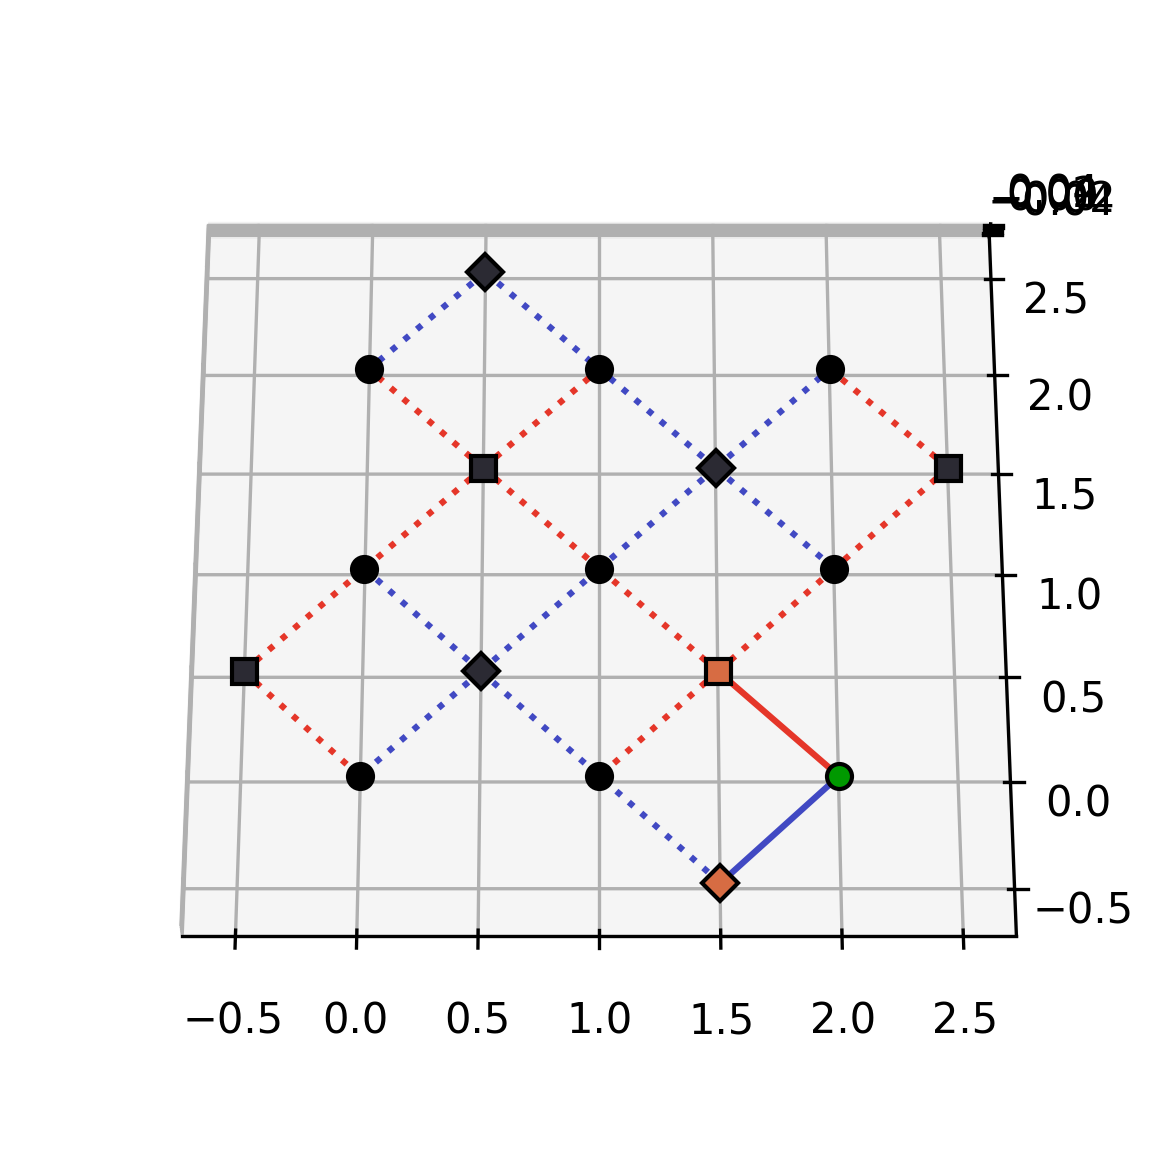

In [11]:

def _plot_data_qubits(data: dict, errors: list[int], group: str, axis: Axes3D):
    for qubit_d, error in zip(data[group]["qubit"], errors):
        axis.plot(
            *qubit_d['loc'], 
            **data[group]["plt_style"], 
            color=data[group]['error_color'][error],
            zorder=3)
        # axis.text(qubit_d['loc'][0], qubit_d['loc'][1]+.2, qubit_d['loc'][2], qubit_d['index'], va='center', ha='center')
        _plot_connections(data, group, qubit_d, error, axis)

def _plot_synd_qubits(data: dict, syndrome: list[int], group: str, axis: Axes3D):
    for qubit_s, synd in zip(data[group]["qubit"], syndrome):
        axis.plot(
            *qubit_s['loc'], 
            **data[group]["plt_style"], 
            color=data[group]["state_colors"][synd],
            zorder=2)
        # axis.text(qubit_s['loc'][0], qubit_s['loc'][1]+.2, qubit_s['loc'][2], qubit_s['index'], va='center', ha='center', color=data[group]["state_colors"][1])

def _plot_connections(data: dict, group: str, qubit_d: dict, error: int, axis: Axes3D):
    for connection in qubit_d['conn']:
        group_s = connection['group']
        group_pauli = data[group_s]['pauli']
        deformation = qubit_d['deformation']
        deformed_pauli = deformations[deformation][group_pauli]
        for idx_s in connection['idxs']:
            qubit_s = data[group_s]['qubit'][idx_s]
            axis.plot(
                *zip(qubit_s['loc'], qubit_d['loc']), 
                color=data[group]["pauli_colors"][deformed_pauli], 
                **data[group]["plt_connect_style"],
                ls = '-' if error != 0 and error != deformed_pauli else ':',
                zorder=1)

def create_legend(axis: Axes3D):
    stab_style = {"marker": "s", "ls": ''}
    A0 = Line2D([0], [0], **stab_style, color='#202020', mec='#000000', label='A stabilizer (not triggered)')
    A1 = Line2D([0], [0], **stab_style, color='#a0a0a0', mec='#000000', label='A stabilizer (triggered)')
    stab_style = {"marker": "D", "ls": ''}
    B0 = Line2D([0], [0], **stab_style, color='#202020', mec='#000000', label='B stabilizer (not triggered)')
    B1 = Line2D([0], [0], **stab_style, color='#a0a0a0', mec='#000000', label='B stabilizer (triggered)')
    axis.legend(handles=[A0, A1, B0, B1], ncol=2)
        
def plot_data(data: dict, errors: list[int], syndromes: dict):
    fig = plt.figure(dpi=300)
    axis: Axes3D = fig.add_subplot(projection='3d')
    for group in data:
        match data[group]["type"]:
            case "data":
                _plot_data_qubits(data, errors, group, axis)
            case "synd":
                _plot_synd_qubits(data, syndromes[group], group, axis)
            case _:
                raise NameError(f"No method for handling group of type: {data[group]["type"]}")
    # create_legend(axis)
    axis.view_init(60, -90, 0)
    axis.set_aspect('equal')

# get_logicals(error_batch[idx], code_deformations)
error_distance = float(error_distance_batch(error_batch, error_probs)[idx])
ic(error_distance)
plot_data(data, error_batch[idx], syndromes[idx])

In [13]:
P_A

Array([0.09950495, 0.09950495, 0.09950495, 0.09950495, 0.09950495,
       0.09950495, 0.09950495, 0.09950495, 0.09950495], dtype=float32)

ic| error_distance: 6.582258224487305


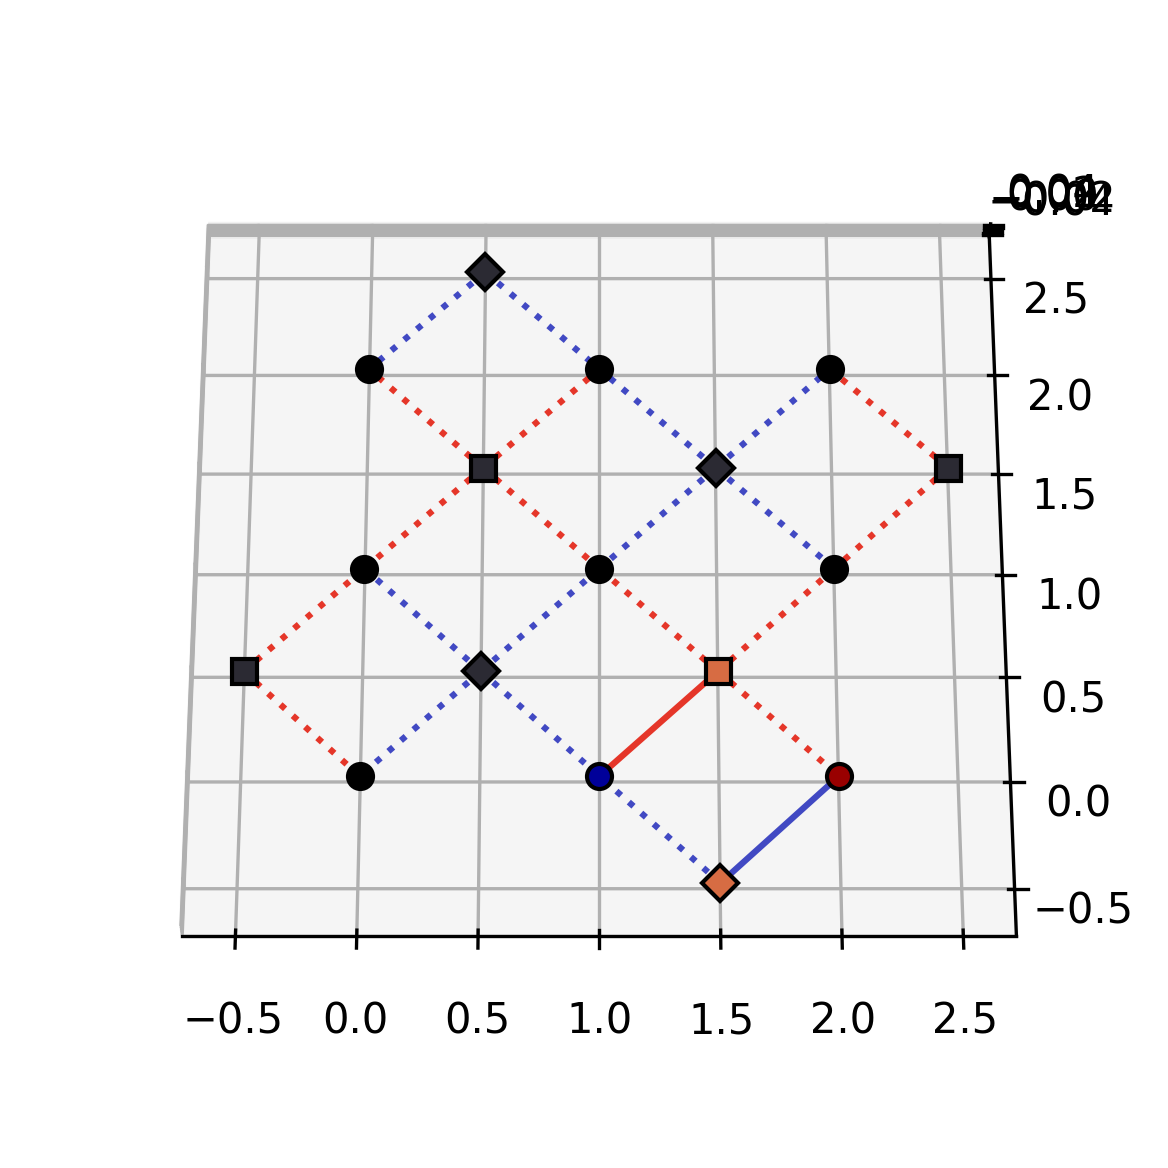

In [12]:
P_tot = sum(error_probs)
P_A = jnp.array([P_tot-error_probs[deformations[deform][1]-1] for deform in code_deformations])
P_B = jnp.array([P_tot-error_probs[deformations[deform][3]-1] for deform in code_deformations])

N = jnp.log(jnp.array(error_probs).mean())

W_A = jnp.log(P_A) / N
W_B = jnp.log(P_B) / N

mwpm_A = Matching(H['Type A syndrome qubits'], weights=W_A)
mwpm_B = Matching(H['Type B syndrome qubits'], weights=W_B)

correction_A_batch = mwpm_A.decode_batch(syndrome_A)
correction_B_batch = mwpm_B.decode_batch(syndrome_B)
correction_regular_batch = jnp.where(correction_A_batch, jnp.where(correction_B_batch, 2, 3), jnp.where(correction_B_batch, 1, 0))
correction_batch = deform_batch(correction_regular_batch, code_deformations)

# get_logicals(correction_batch[idx], code_deformations)
error_distance = float(error_distance_batch(correction_batch, error_probs)[idx])
ic(error_distance)
plot_data(data, correction_batch[idx], syndromes[idx])

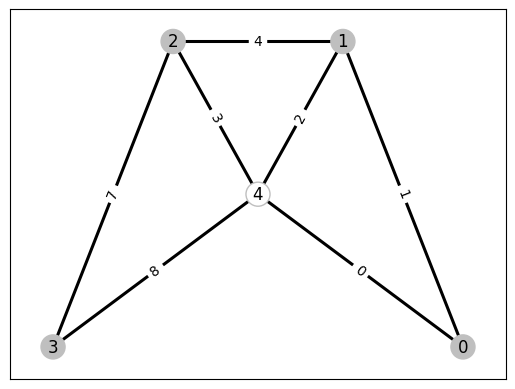

In [27]:
mwpm_A.draw()

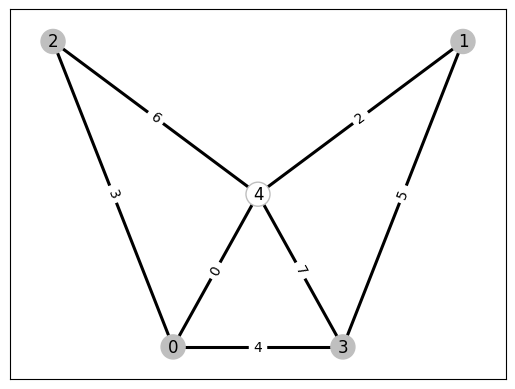

In [28]:
mwpm_B.draw()

ic| logicals: {'X': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32),
               'Z': Array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)}


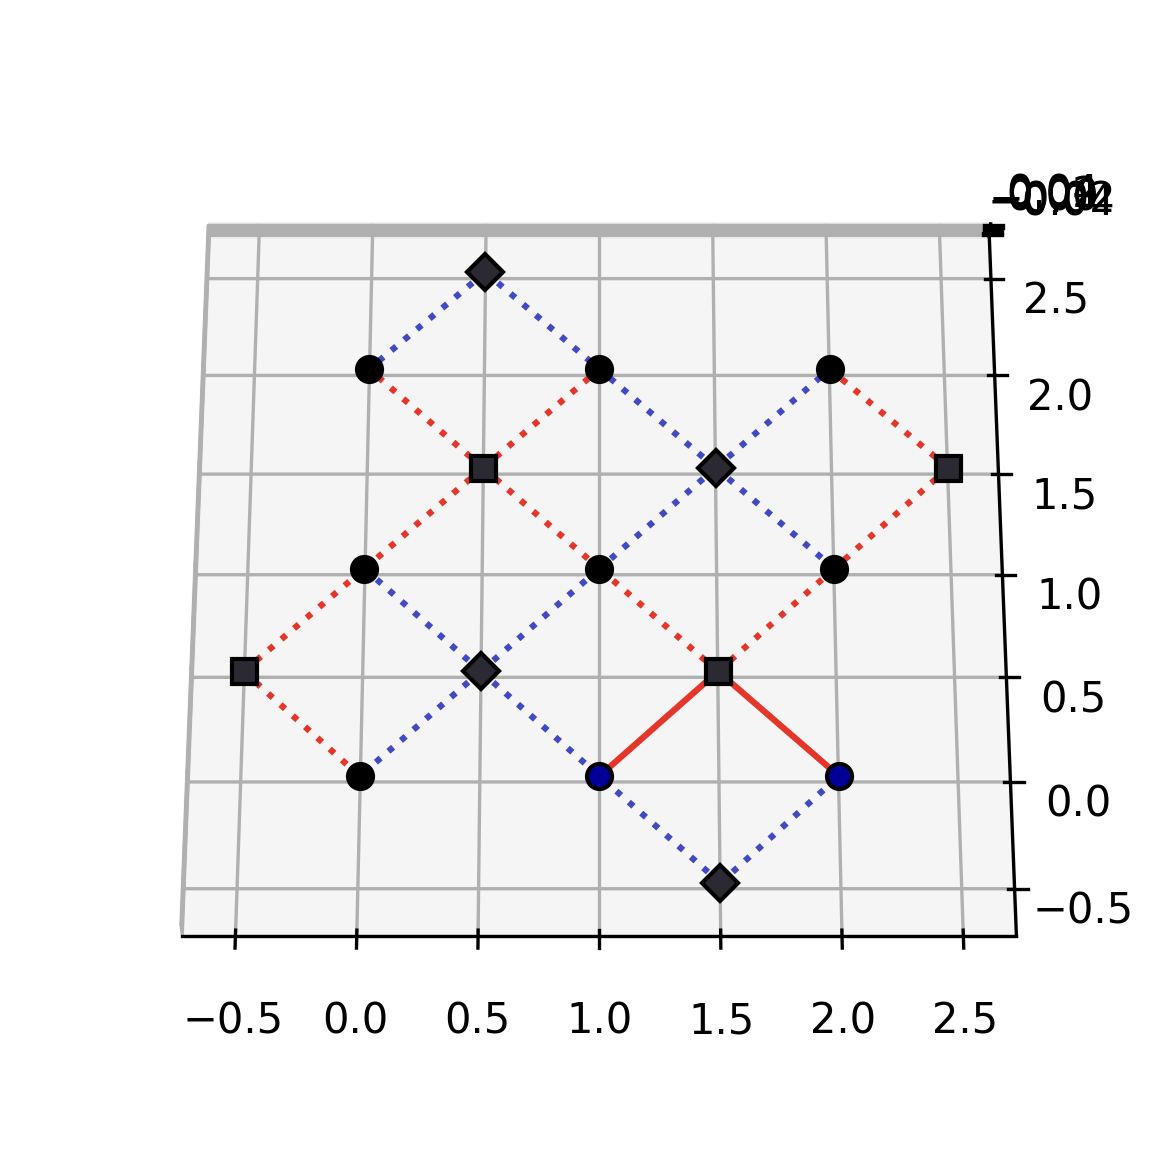

In [29]:
def combine_errors_and_correction_batch(error_batch, correction_batch):
    def combine_errors_and_correction(errors, correction):
        merge = jnp.array([
            [0,1,2,3],
            [1,0,3,2],
            [2,3,0,1],
            [3,2,1,0]
        ])
        return jnp.array([merge[e,c] for e,c in zip(errors, correction)])
    combine_batch = jax.vmap(
        combine_errors_and_correction,
        in_axes=(0, 0),
        out_axes=0)
    return combine_batch(error_batch, correction_batch)

comb_batch = combine_errors_and_correction_batch(error_batch, correction_batch)

comb_inv_deformed = deform_batch_inv(comb_batch, code_deformations)
syndrome_A_final = jnp.sum(((comb_inv_deformed==2) + (comb_inv_deformed==3))[:,None,:] * H['Type A syndrome qubits'], axis=-1) % 2
syndrome_B_final = jnp.sum(((comb_inv_deformed==1) + (comb_inv_deformed==2))[:,None,:] * H['Type B syndrome qubits'], axis=-1) % 2
syndromes_final = [{
    'Type A syndrome qubits': syndrome_A_final[i],
    'Type B syndrome qubits': syndrome_B_final[i],
} for i in range(syndrome_A_final.shape[0])]

logicals = logical_error_batch(comb_batch, code_deformations)
ic(logicals)
plot_data(data, comb_batch[idx], syndromes_final[idx])

# Benchmark

In [16]:
from time import time

batch_size = 100000
d = 3
p_tot = .05

times = [time()]
# Create the desired size surface code
data = surface_code_data(distance=d)
qubit_counts = get_qubit_count(data)
H = parity_check_matrix(data)
code_deformations = jnp.array([qubit['deformation'] for qubit in data['Data qubit']['qubit']])

times.append(time())
# Calculate the error probabilities
nu = .5
error_probs = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]

times.append(time())
# Generate the true errors that happen on the code
subkey, key = jax.random.split(key)
error_batch = jax_create_error_batch(*error_probs, size=qubit_counts['dq']['Data qubit'], batch_size=batch_size, key=subkey)

times.append(time())
# Do the inverse deformation and calculate the syndromes
error_batch_regular = deform_batch_inv(error_batch, code_deformations)
syndrome_A = jnp.sum(((error_batch_regular==2) + (error_batch_regular==3))[:,None,:] * H['Type A syndrome qubits'], axis=-1) % 2
syndrome_B = jnp.sum(((error_batch_regular==1) + (error_batch_regular==2))[:,None,:] * H['Type B syndrome qubits'], axis=-1) % 2

times.append(time())
# Calculate the weights for the MWPM-algorithm
P_A = jnp.array([P_tot-error_probs[deformations[deform][1]-1] for deform in code_deformations])
P_B = jnp.array([P_tot-error_probs[deformations[deform][3]-1] for deform in code_deformations])
N = jnp.log(jnp.array(error_probs).mean())
W_A = jnp.log(P_A) / N
W_B = jnp.log(P_B) / N
mwpm_A = Matching(H['Type A syndrome qubits'], weights=W_A)
mwpm_B = Matching(H['Type B syndrome qubits'], weights=W_B)

times.append(time())
# Run the MWPM-algorithm on the data
correction_A_batch = mwpm_A.decode_batch(syndrome_A)
correction_B_batch = mwpm_B.decode_batch(syndrome_B)
correction_regular_batch = jnp.where(correction_A_batch, jnp.where(correction_B_batch, 2, 3), jnp.where(correction_B_batch, 1, 0))
correction_batch = deform_batch(correction_regular_batch, code_deformations)

times.append(time())
# Combine the errors with the correction
comb_batch = combine_errors_and_correction_batch(error_batch, correction_batch)
logicals = logical_error_batch(comb_batch, code_deformations)
logical_error = jnp.logical_or(*logicals.values())

times.append(time())
names = ["Create the desired size surface code", "Calculate the error probabilities", "Generate the true errors that happen on the code", "Do the inverse deformation and calculate the syndromes", "Calculate the weights for the MWPM-algorithm", "Run the MWPM-algorithm on the data", "Combine the errors with the correction"]
for i in range(len(times)-1):
    print(f'{times[i+1]-times[i]:.3f}s \t{names[i]}')

0.004s 	Create the desired size surface code
0.000s 	Calculate the error probabilities
0.509s 	Generate the true errors that happen on the code
0.366s 	Do the inverse deformation and calculate the syndromes
0.026s 	Calculate the weights for the MWPM-algorithm
0.066s 	Run the MWPM-algorithm on the data
0.840s 	Combine the errors with the correction


In [17]:
batch_size = 100000


P = jnp.linspace(.001, .2, 100)
E: dict[str, list] = {}
for d in [3,5,7,9,11]:
    E[str(d)] = []

    # Create the desired size surface code
    data = surface_code_data(distance=d)
    qubit_counts = get_qubit_count(data)
    H = parity_check_matrix(data)
    code_deformations = jnp.array([qubit['deformation'] for qubit in data['Data qubit']['qubit']])

    for p_tot in P:
        print(f'{d = } | {p_tot = :.3%}', end='\r')
        # Calculate the error probabilities
        nu = .5
        error_probs = [
            1 / (2 * (nu + 1)) * p_tot,
            1 / (2 * (nu + 1)) * p_tot,
            nu / (nu + 1) * p_tot,
        ]

        # Generate the true errors that happen on the code
        subkey, key = jax.random.split(key)
        error_batch = jax_create_error_batch(*error_probs, size=qubit_counts['dq']['Data qubit'], batch_size=batch_size, key=subkey)

        # Do the inverse deformation and calculate the syndromes
        error_batch_regular = deform_batch_inv(error_batch, code_deformations)
        syndrome_A = jnp.sum(((error_batch_regular==2) + (error_batch_regular==3))[:,None,:] * H['Type A syndrome qubits'], axis=-1) % 2
        syndrome_B = jnp.sum(((error_batch_regular==1) + (error_batch_regular==2))[:,None,:] * H['Type B syndrome qubits'], axis=-1) % 2

        # Calculate the weights for the MWPM-algorithm
        P_A = jnp.array([P_tot-error_probs[deformations[deform][1]-1] for deform in code_deformations])
        P_B = jnp.array([P_tot-error_probs[deformations[deform][3]-1] for deform in code_deformations])
        N = jnp.log(jnp.array(error_probs).mean())
        W_A = jnp.log(P_A) / N
        W_B = jnp.log(P_B) / N
        mwpm_A = Matching(H['Type A syndrome qubits'], weights=W_A)
        mwpm_B = Matching(H['Type B syndrome qubits'], weights=W_B)

        # Run the MWPM-algorithm on the data
        correction_A_batch = mwpm_A.decode_batch(syndrome_A)
        correction_B_batch = mwpm_B.decode_batch(syndrome_B)
        correction_regular_batch = jnp.where(correction_A_batch, jnp.where(correction_B_batch, 2, 3), jnp.where(correction_B_batch, 1, 0))
        correction_batch = deform_batch(correction_regular_batch, code_deformations)

        # Combine the errors with the correction
        comb_batch = combine_errors_and_correction_batch(error_batch, correction_batch)
        logicals = logical_error_batch(comb_batch, code_deformations)
        logical_error = jnp.logical_or(*logicals.values())
        E[str(d)].append(logical_error.mean())

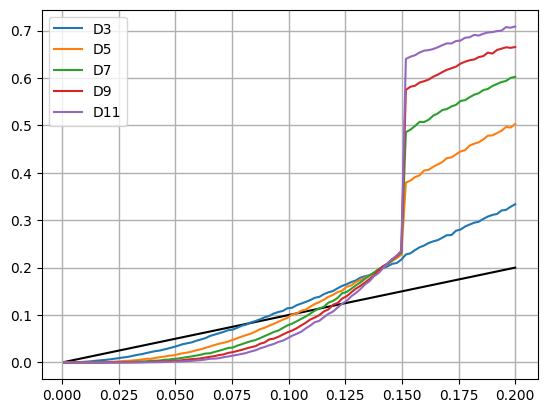

In [19]:
plt.figure()
plt.plot(P, P, color='k')
plt.plot(P, E['3'], label='D3')
plt.plot(P, E['5'], label='D5')
plt.plot(P, E['7'], label='D7')
plt.plot(P, E['9'], label='D9')
plt.plot(P, E['11'], label='D11')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.grid(which='major', lw=1)
plt.grid(which='minor', lw=.2)
plt.show()

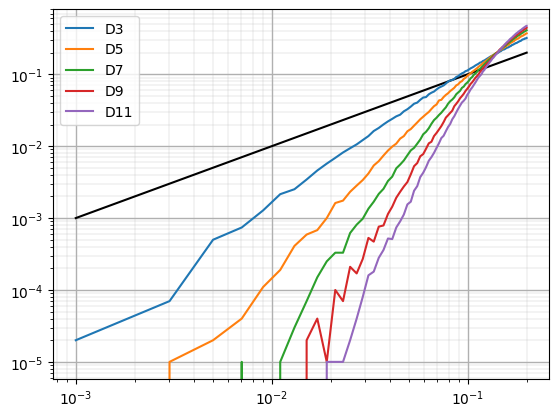

In [ ]:
plt.figure()
plt.plot(P, P, color='k')
plt.plot(P, E['3'], label='D3')
plt.plot(P, E['5'], label='D5')
plt.plot(P, E['7'], label='D7')
plt.plot(P, E['9'], label='D9')
plt.plot(P, E['11'], label='D11')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(which='major', lw=1)
plt.grid(which='minor', lw=.2)
plt.show()